In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from segmentation_eva_n import *
from plot_eva import *
from skimage import img_as_float
from skimage import restoration
import os

In [5]:
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'

In [189]:
def main(analysis = "ctrl"):
    path = "20170814_H9drugAll_0815_gel_I_150Pa/"
    imageformat=".tif"
    imfilelist=[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imageformat)]
    data = [sentence for sentence in imfilelist if analysis in sentence]
    
    mean_int_nucleus_inside_lst = []
    mean_int_nucleus_outside_lst = []
    
    mean_int_cyto_inside_lst = []
    mean_int_cyto_outside_lst = []
    
    
    for image in data:
        img = io.imread(image)
        actin, yap, dapi = img.transpose(3,0,1,2)
        bbox = roi(dapi)
        dapi_roi = dapi[bbox[0]]
        yap_roi = yap[bbox[0]]
        dapi_float = img_as_float(dapi_roi)
        dapi_float_tvc = restoration.denoise_tv_chambolle(dapi_roi, weight = 0.05)
        dapi_seg, mask_yap, idx, yap_int, dapi_roi_z = segment_ind_cells(dapi_float_tvc, yap_roi)
        cleaned = segment_nucleus(dapi_roi_z)
        
        regprops_yap_nucleus, _ = regionprop_protein_in_mask(yap_int, cleaned, dapi_seg, outside_nu=False)
        regprops_yap_cyto, _ = regionprop_protein_in_mask(yap_int, cleaned, dapi_seg, outside_nu=True)
        
        #regprops_yap_nucleus =  measure.regionprops(dapi_seg, yap_int)
        label_outside_list = outer_layer(mask_yap, dapi_seg, 3)
        
        
        mean_int_nucleus_inside, mean_int_nucleus_outside = list_mean_int_in_out(regprops_yap_nucleus, 
                                                                                 label_outside_list, 
                                                                                 yap_int)
        
        
        mean_int_cyto_inside, mean_int_cyto_outside = list_mean_int_in_out(regprops_yap_cyto, 
                                                                                 label_outside_list, 
                                                                                 yap_int)
        
        mean_int_nucleus_inside_lst.extend(mean_int_nucleus_inside)
        mean_int_nucleus_outside_lst.extend(mean_int_nucleus_outside)
        
        mean_int_cyto_inside_lst.extend(mean_int_nucleus_inside)
        mean_int_cyto_outside_lst.extend(mean_int_nucleus_outside)
        
    return((mean_int_nucleus_inside_lst, mean_int_nucleus_outside_lst,
            mean_int_cyto_inside_lst, mean_int_cyto_outside_lst)) 
    

In [190]:
if __name__ == '__main__':
    to_analyse = ["ctrl", "cytoD", "SMIFH2", "Y2"]
    
    df_final = []
    
    for file in to_analyse:
        print(file)
        result = main(analysis = file)
        
        data_inside = {"mean intensity nucleus": result[0],
                        "mean intensity cyto": result[2],
                       "where": ["inside"] * len(result[0]),
                       "drug": [file] * len(result[0])}
        data_pd_ins = pd.DataFrame(data_inside)
        
        data_outside = {"mean intensity nucleus": result[1],
                        "mean intensity cyto": result[3],
                        "where": ["outside"] * len(result[1]),
                        "drug": [file] * len(result[1])}
        data_pd_out = pd.DataFrame(data_outside)
        
        frames = [data_pd_ins, data_pd_out]
        df = pd.concat(frames)
        df_final.append(df)
    


ctrl


/Users/Espenel/anaconda/envs/eva/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


    drug  mean intensity    where
0   ctrl     7774.985735   inside
1   ctrl    10315.646597   inside
2   ctrl     8244.565168   inside
3   ctrl     9021.495555   inside
4   ctrl     8693.115188   inside
5   ctrl     9292.501638   inside
6   ctrl    21643.924182   inside
7   ctrl    14954.553546   inside
8   ctrl     8266.629452   inside
9   ctrl     9077.960300   inside
10  ctrl    10763.981037   inside
11  ctrl     7593.206442   inside
12  ctrl     8074.861532   inside
13  ctrl    12979.959958   inside
14  ctrl    11943.362506   inside
15  ctrl    10097.097280   inside
16  ctrl     7362.875229   inside
17  ctrl     7953.735717   inside
18  ctrl    25092.512950   inside
19  ctrl     9108.621872   inside
20  ctrl    19776.106817   inside
21  ctrl     9190.542948   inside
22  ctrl    11960.859754   inside
23  ctrl    14264.396489   inside
24  ctrl     8820.164355   inside
25  ctrl    13719.413203   inside
26  ctrl    14008.405928   inside
27  ctrl    12471.322841   inside
28  ctrl    14

In [207]:
df_final = df_nucleus

In [232]:
df_cyto.columns

Index(['drug', 'mean intensity', 'where'], dtype='object')

In [256]:
mean_ctrl_cyto = df_cyto.loc[(df_cyto['drug'] == 'ctrl') & (df_cyto['where'] == 'outside')]

In [257]:
mean_ctrl_nuc = df_nucleus.loc[(df_nucleus['drug'] == 'ctrl') & (df_nucleus['where'] == 'outside')]

In [258]:
np.mean(mean_ctrl_nuc['mean intensity']) / np.mean(mean_ctrl_cyto['mean intensity'])

1.4381222843596149

In [217]:
len(df_nucleus["mean intensity"].values)

819

In [195]:
df_nucleus.to_csv('int_nucleus.csv')

In [196]:
df_cyto.to_csv('int_cyto.csv')

In [143]:
#data = pd.concat(dict_df.values(),axis=0,keys=dict_df.keys())

In [1]:
import seaborn as sns

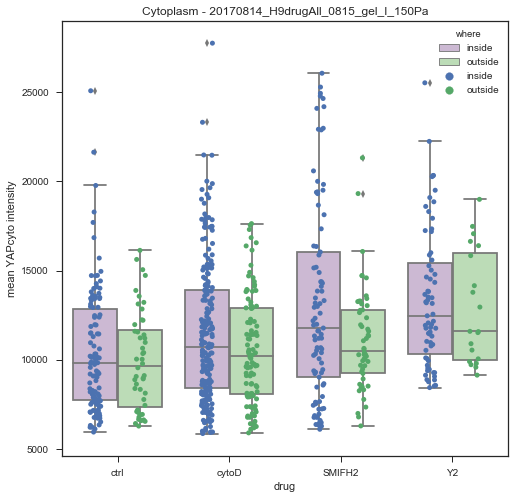

In [308]:
sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
#x="day", y="total_bill", hue="sex", data=tips, palette="PRGn"
ax = sns.boxplot(x = "drug", y="mean intensity", hue = "where", data=df_cyto, palette="PRGn").set_title("Cytoplasm - 20170814_H9drugAll_0815_gel_I_150Pa")
ax = sns.stripplot(x = "drug", y="mean intensity", hue = "where", data=df_cyto, jitter=True,dodge = True);

#sns.despine(offset=10, trim=True)

plt.ylabel('mean YAPcyto intensity')
plt.savefig('Cytoplasm-150Pa.png')

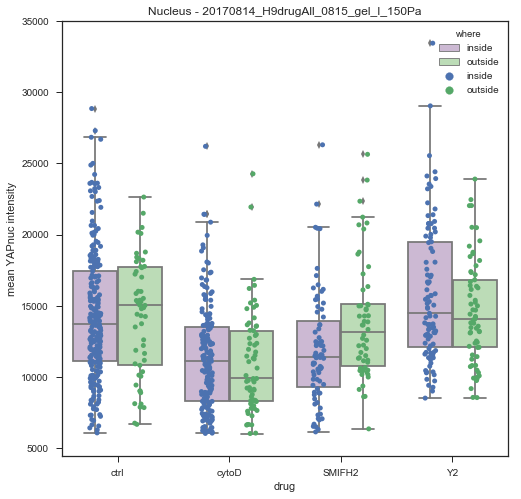

In [310]:
sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
#x="day", y="total_bill", hue="sex", data=tips, palette="PRGn"
sns.boxplot(x = "drug", y="mean intensity", hue = "where", data=df_nucleus, palette="PRGn").set_title("Nucleus - 20170814_H9drugAll_0815_gel_I_150Pa")
ax = sns.stripplot(x = "drug", y="mean intensity", hue = "where", data=df_nucleus, jitter=True,dodge = True);
#sns.despine(offset=10, trim=True)

plt.ylabel('mean YAPnuc intensity')
plt.savefig('Nucleus-150Pa.png')

In [7]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [71]:
path = "20170814_H9drugAll_0815_gel_I_150Pa/"

In [92]:
img = io.imread(path + "/" + "ctrl_150_3.tif")

In [93]:
actin, yap, dapi = img.transpose(3,0,1,2)

In [94]:
bbox = roi(dapi)

In [95]:
dapi_roi = dapi[bbox[0]]
yap_roi = yap[bbox[0]]

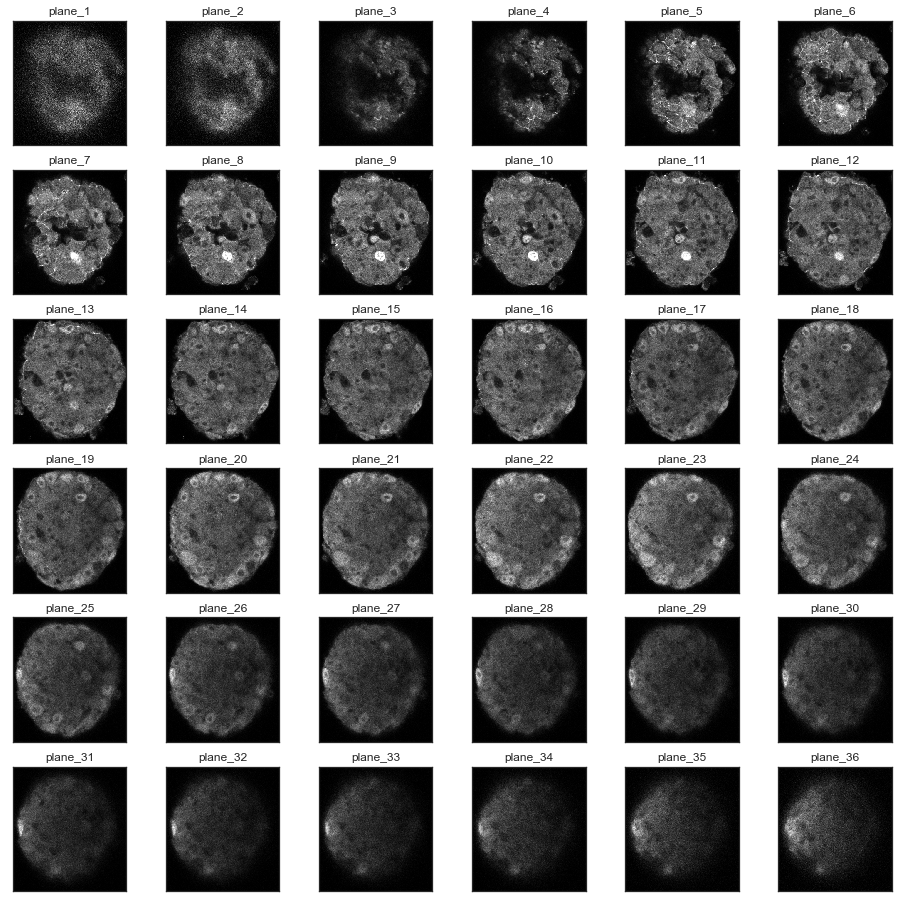

In [96]:
display_all_zsteps(yap_roi)

In [97]:
dapi_float = img_as_float(dapi_roi)
dapi_float_tvc = restoration.denoise_tv_chambolle(dapi_roi, weight = 0.05)

In [98]:
dapi_seg, mask_yap, idx, yap_int, dapi_roi_z = segment_ind_cells(dapi_float_tvc, yap_roi)

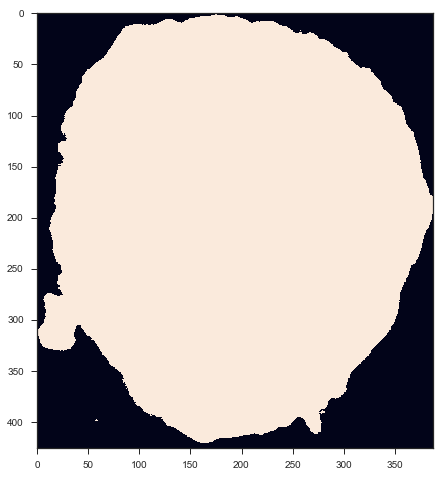

In [99]:
plt.imshow(mask_yap[1])

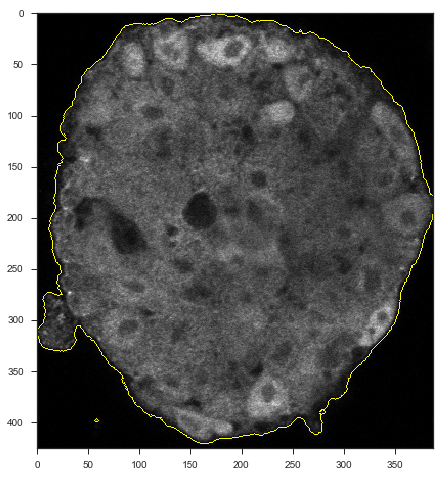

In [100]:
plt.imshow(segmentation.mark_boundaries(yap_int[1], 
                                        mask_yap[1]))

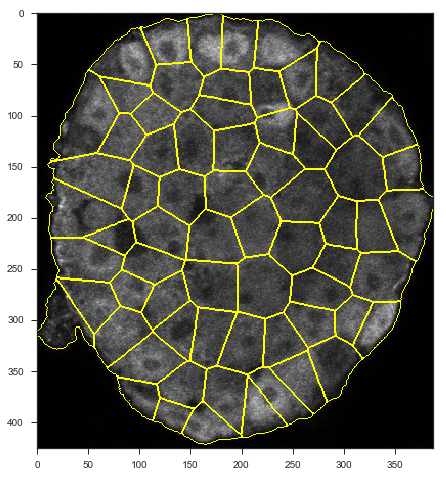

In [101]:
plt.imshow(segmentation.mark_boundaries(yap_int[3], 
                                        dapi_seg[3]))

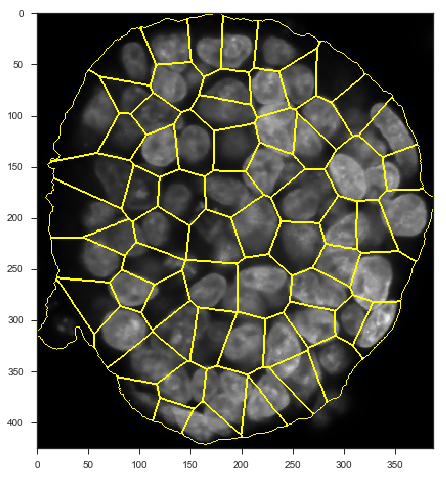

In [102]:
plt.imshow(segmentation.mark_boundaries(dapi_float_tvc[14], 
                                        dapi_seg[3]))

In [103]:
cleaned = segment_nucleus(dapi_roi_z)

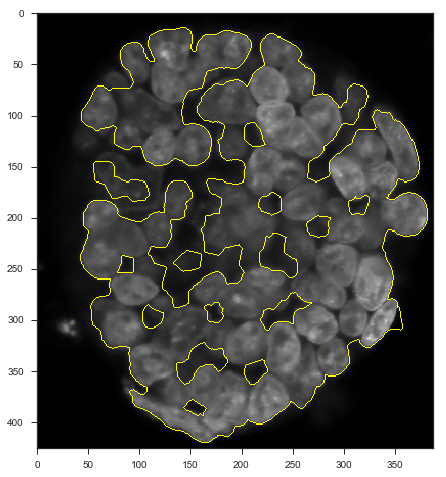

In [104]:
plt.imshow(segmentation.mark_boundaries(dapi_roi_z[3], 
                                        cleaned[3]))

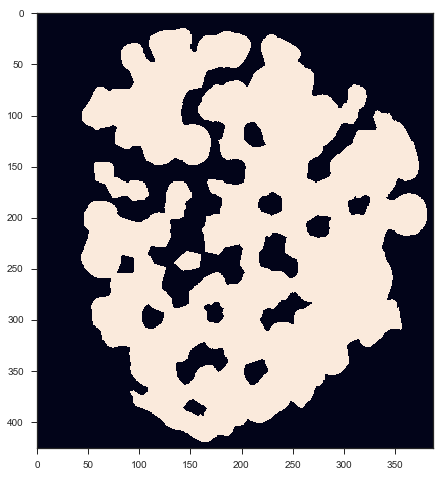

In [105]:
plt.imshow(cleaned[3])

In [106]:
regprops_yap_nucleus, protein_nu = regionprop_protein_in_mask(yap_int, cleaned, dapi_seg, outside_nu=False)

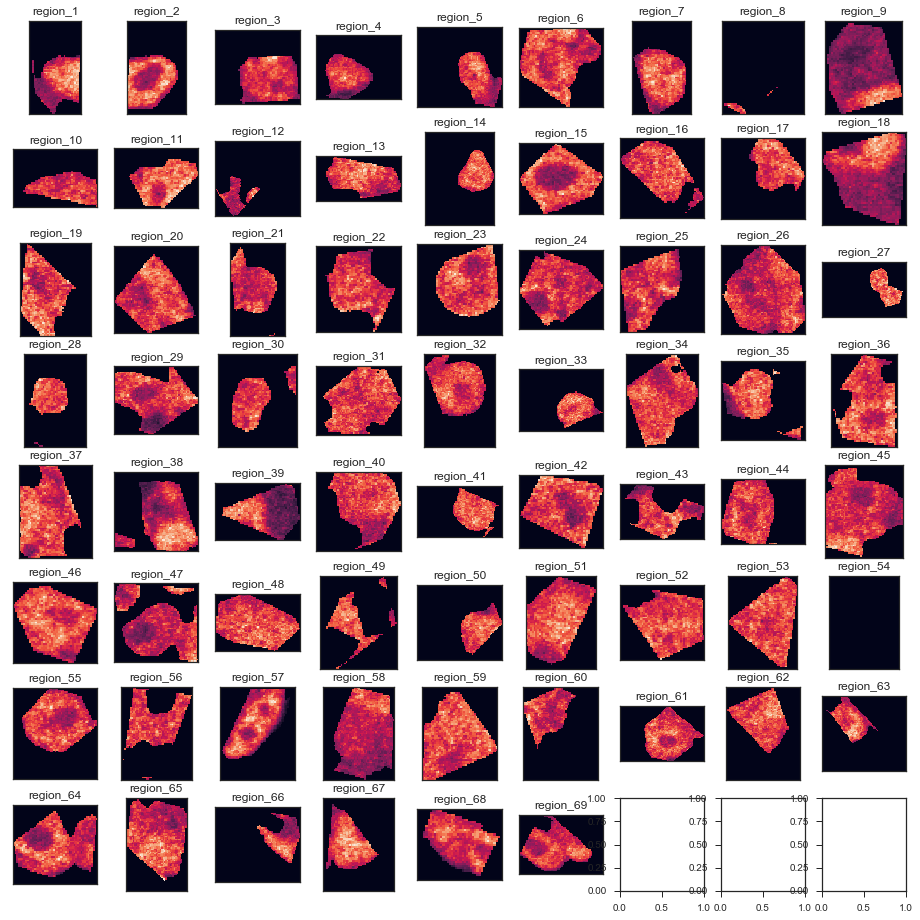

In [107]:
plot_list_int(regprops_yap_nucleus)

In [108]:
label_outside_list = outer_layer(mask_yap, dapi_seg, 3)

/Users/Espenel/anaconda/envs/eva/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


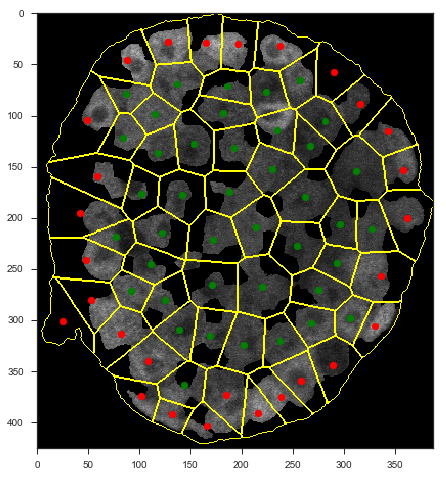

In [109]:
fig, ax = plt.subplots(figsize = (8,8))

ax.imshow(segmentation.mark_boundaries(protein_nu[5],
                                            dapi_seg[5]))

for j in regprops_yap_nucleus:
    if j.label in label_outside_list:
        plt.scatter(j.centroid[2], j.centroid[1], c = 'r')
    if j.label not in label_outside_list:
        plt.scatter(j.centroid[2], j.centroid[1], c = 'g')

In [110]:
mean_int_nucleus_inside, mean_int_nucleus_outside = list_mean_int_in_out(regprops_yap_nucleus, label_outside_list, yap_int)

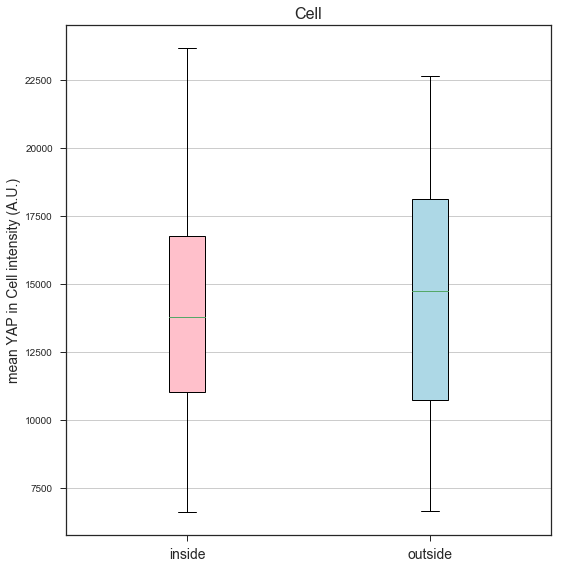

In [111]:
box_plot_mean(mean_int_nucleus_inside, mean_int_nucleus_outside, title = "Cell")